# Bitcoin - Complex Graph Analysis

### This notebook was created to enable fellows to quickly reproduce the paper ``

## Steps
1. [Data collection](#1.-Data-collection)
2. [Data preparation](#2.-Data-preparation)
3. [Data Analysis](#3.-Data-Analysis)  
    3.1. [Load Data](#3.1.-Load-data)  
    3.2. [General Stats](#3.2.-General-Stats)  
    3.3. [CoinJoin-adjusted User Graph](#3.3-Bitcoin---CoinJoin-adjusted-User-Graph)  
    3.4. [Network Properties](#3.4.-Network-Properties)  
    3.5. [Public Keys and Users](#3.5.-Public-Key-and-Users)
4. [Outtakes](#Outtakes)

***

## 1. Data collection

In [ ]:
%run run.py -loc data -collectvalue -collectblk -upload -parquet -mp

 ```console
 The following arguments can be used:
  -h, --help                                  show this help message and exit
  -sf STARTFILE, --startfile STARTFILE        .blk start file (included) - default: blk00000.dat
  -ef ENDFILE, --endfile ENDFILE              .blk end file (excluded) - default: None
  -st STARTTX, --starttx STARTTX              start transaction id (included) - default: None
  -et ENDTX, --endtx ENDTX                    end transaction id (excluded) - default: None
  -ets ENDTS, --endts ENDTS                   end timestamp of block - default: None
  -loc BLKLOCATION, --blklocation BLKLOCATION .blk|.csv file location - default: ~/.bitcoin/blocks
  -path TARGETPATH, --targetpath TARGETPATH   path to store raw edges locally - default: ./
  -collectvalue, --collectvalue               collect output values - default: No
  -collectblk, --collectblk                   collect blk file numbers with every edge - default: No
  -upload, --upload                           upload edges to google bigquery - default: False
  -parquet, --parquet                         use parquet format - default: False
  -mp, --multiprocessing                      use multiprocessing - default: False
  -ut UPLOADTHRESHOLD, --uploadthreshold      uploading threshold for parquet files - default: 5
  -bucket BUCKET, --bucket BUCKET             bucket name to store parquet files - default: btc_<timestamp>
  -c CREDENTIALS, --credentials CREDENTIALS   path to google credentials (.*json)-default: ./.gcpkey/.*json
  -project PROJECT, --project PROJECT         google cloud project name - default: btcgraph
  -ds DATASET, --dataset DATASET              bigquery data set name - default: btc
  -tid TABLEID, --tableid TABLEID             bigquery table id - default: bitcoin_transactions
 ```

***

## 2. Data preparation 
### The data preparation steps has been carried out using SQL (BigQuery). To recap, the following steps were taken to transform the transaction graph into a CoinJoin-adjusted usergraph:
   * Partition table into yearly chunks
   * Create separate table that doesn't include coinbase tx and txs with OP_Returns or invalid output scripts
   * Create Address => ID mapping
   * Create Tx => ID mapping
   * Use mappings to reconstruct the transaction graph (reduces size massively)
   * Detect Wasabi CoinJoin Transaction IDs
   * Detect Samurai CoinJoin Transaction IDs
   * Create table containing a CoinJoin filtered transaction graph 
   * Copy Address => ID mapping, clone the ID column and add it with the column name ``clusterid``
   * Create list of ``linking_IDs`` which are IDs of transactions that can be linked through a common input address
   * Perform user clustering - on the standard (not adjusted) usergraph and the CoinJoin-adjusted usergrah
   * Create final user graph
#### Have a look at the ``data_preparation_sql.py`` files which contains all the queries used

## 3. Data Analysis

In [1]:
import os 
import math
import numpy as np
import pandas as pd
from datetime import datetime
from google.cloud import storage, bigquery
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({
  "text.usetex": True
  #"font.family": "Helvetica"
})

pd.options.display.float_format = '${:,.2f}'.format
pd.options.mode.chained_assignment = None
    
credentials_path = "./.gcpkey/btcgraph.json"
bq_project       = "wu-btcgraph"
bq_dataset       = "btc"

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

if not os.path.isdir("./pictures"):
    os.mkdir("./pictures")
    
    
    
# Least Sqare Line 
# E(t) = N(t)^a

def least_squares_line(cnc, cec, n = None):
    if n:
        cnc = cnc[-n:]
        cec = cec[-n:]
    
    ln_x = list(map(math.log, cnc))
    ln_y = list(map(math.log, cec))

    
    mean_ln_x = np.mean(ln_x)
    mean_ln_y = np.mean(ln_y)

    xi_x = list(map(lambda x: x - mean_ln_x, ln_x))
    yi_y = list(map(lambda x: x - mean_ln_y, ln_y))        
    
    xi_x_yi_y = list(map(lambda x,y: x*y, xi_x, yi_y))
    xi_x2     = list(map(lambda x: x**2, xi_x))

    powerlaw_e = sum(xi_x_yi_y)/sum(xi_x2)
    constant   = math.exp(mean_ln_y - powerlaw_e*mean_ln_x)
    return powerlaw_e, constant

    #print("Densification power law exponent of {:.3f} with a constant of {:.3f}".format(powerlaw_e,constant))
    #print("Equation: y = {:.3f}**{:.3f}".format(constant,powerlaw_e))


def get_fitting_result(X, Y, plot_figure=False, fit_intercept=True):

    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_ = poly.fit_transform(X.reshape(-1, 1))

    clf = linear_model.LinearRegression(fit_intercept=fit_intercept)
    clf.fit(X_, Y)
    Y_NEW = clf.predict(X_)
    if plot_figure:
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
        plt.scatter(X, Y)
        plt.plot(X, Y_NEW)

    rmse = np.sqrt(mean_squared_error(Y,Y_NEW))
    r2 = r2_score(Y,Y_NEW)

    print(f"RMSE: {rmse}")
    print(f"R²:   {r2}")
    equation = "${:,.0f} + {:,.2f}x {:,.3f}x^2\ \mid\ R^2 = {:,.2f}$".format(clf.intercept_,clf.coef_[0],clf.coef_[1], r2)
    return equation, Y_NEW, (clf.intercept_, clf.coef_[0], clf.coef_[1])

### 3.1. Load data

In [2]:
USE_LOCAL_COPIES_IF_POSSIBLE = True
CREATE_LOCAL_COPIES = True
def query(bq_table):
    _query = """
            SELECT    * 
            FROM      `{}.{}.{}`
            """.format(bq_project,bq_dataset,bq_table)
    return _query

QUERIES = ["stats_invalids", "stats_metrics_summary_per_month_pubk", 
           "stats_metrics_summary_per_month_user_WCJ", "stats_general_metrics",
           "stats_user_count_cum_UG", "stats_user_count_cum_WCJ", 
           "stats_degree_distribution_total_UG", "stats_degree_distribution_in_degree_UG", 
           "stats_degree_distribution_out_degree_UG", 
           "stats_degree_distribution_total_WCJ", "stats_degree_distribution_in_degree_WCJ", 
           "stats_degree_distribution_out_degree_WCJ", "stats_blk_files", 
           "coinj_metrics_over_time", "stats_active_time_G", 
           "stats_active_time_WCJ", "coinj_stats",
           "usergraph_clustersizes_distribution_UG", 
           "usergraph_clustersizes_distribution_WCJ", "stats_summary", 
           "stats_avg_outdegree_UG", "stats_avg_outdegree_WCJ", "stats_coinbase",
           "coinj_total_per_provider", "stats_coinj_vs_total_edges_blk",
           "stats_largest_cluster_services", "stats_active_time_avg_G",
           "stats_active_time_avg_WCJ", "stats_most_active_public_key"] 

if USE_LOCAL_COPIES_IF_POSSIBLE:
    try:
        DF
    except:
        DF = {}
else:
    DF = {}

for bq_table in QUERIES:
    try:
        if not USE_LOCAL_COPIES_IF_POSSIBLE:
            raise
        DF[bq_table] = pd.read_csv(".local_copies/" + bq_table + ".csv")
        print("{:<49} read from local storage".format(bq_table))

    except:
        try:
            DF[bq_table]
            pass
        except KeyError:
            DF[bq_table] = pd.read_gbq(query(bq_table), bq_project)
            print("{:<49} read from Google BigQuery".format(bq_table))

print(f"{len(DF)} tables successfully loaded into the RAM")

# Make local copies
if CREATE_LOCAL_COPIES:
    for table in DF:
        DF[table].to_csv(".local_copies/" + table + ".csv", index=None)

stats_invalids                                    read from local storage
stats_metrics_summary_per_month_pubk              read from local storage
stats_metrics_summary_per_month_user_WCJ          read from local storage
stats_general_metrics                             read from local storage
stats_user_count_cum_UG                           read from local storage
stats_user_count_cum_WCJ                          read from local storage
stats_degree_distribution_total_UG                read from local storage
stats_degree_distribution_in_degree_UG            read from local storage
stats_degree_distribution_out_degree_UG           read from local storage
stats_degree_distribution_total_WCJ               read from local storage
stats_degree_distribution_in_degree_WCJ           read from local storage
stats_degree_distribution_out_degree_WCJ          read from local storage
stats_blk_files                                   read from local storage
coinj_metrics_over_time               

***

### 3.2. General Stats

In [9]:
# Table in LATEX format
df_cnc = DF["stats_general_metrics"].sort_values("year").set_index("year")
print("snapshot & \#txs & \#edges & \#nodes \\\ \n\hline")
for i,j in df_cnc.iterrows():
    print("31.12."+str(i)+" &", " & ".join(["{:,.0f}".format(int(jj)) for jj in j])+" \\\ ")

snapshot & \#txs & \#edges & \#nodes \\ 
\hline
31.12.2009 & 32,709 & 36,118 & 32,611 \\ 
31.12.2010 & 218,012 & 357,980 & 176,326 \\ 
31.12.2011 & 2,119,777 & 8,699,936 & 2,768,497 \\ 
31.12.2012 & 10,572,827 & 50,619,652 & 8,707,387 \\ 
31.12.2013 & 30,216,068 & 165,406,409 & 24,806,749 \\ 
31.12.2014 & 55,479,788 & 536,722,857 & 58,880,264 \\ 
31.12.2015 & 101,153,811 & 1,104,704,739 & 115,225,325 \\ 
31.12.2016 & 183,780,434 & 1,707,653,884 & 209,678,116 \\ 
31.12.2017 & 287,843,663 & 2,769,993,445 & 353,414,610 \\ 
31.12.2018 & 369,239,299 & 3,615,499,650 & 464,829,692 \\ 
31.12.2019 & 489,022,946 & 4,747,563,790 & 595,594,675 \\ 
31.12.2020 & 601,576,444 & 5,931,290,239 & 759,260,121 \\ 
31.12.2021 & 686,642,867 & 7,427,788,006 & 901,545,413 \\ 


In [10]:
# Invalid transactions/OP_RETURNs
for i, j in DF["stats_invalids"].iterrows():
    print("{:<10}: {:>10,} edges  {:>10,} txs".format(j.address, j.edges, j.txs))
 

df = DF["stats_coinbase"]
print("{:<10}: {:>10,} edges  {:>10,} txs (excl. +2 tx with similar tx hashes)".format("coinbase", int(df.coinbase_edges), int(df.coinbase_txs)))

df = DF["stats_invalids"].set_index("address")
invalids = df.loc["invalid", "txs"] + df.loc["unknown", "txs"]
print("\n{:<10}: {:>10,} %".format("Valid  txs",round((1-invalids/df_cnc.iloc[-1]["txs_c"])*100,2)))
print("\nCoinJoins :")
sam = int(DF["coinj_total_per_provider"][DF["coinj_total_per_provider"]["name"]=="samurai"]["txs"])
was = int(DF["coinj_total_per_provider"][DF["coinj_total_per_provider"]["name"]=="wasabi"]["txs"])
print("{:<10}: {:>10,} txs".format("total",was+sam))
print("{:<10}: {:>10,} txs".format("wasabi",was))
print("{:<10}: {:>10,} txs".format("samurai",sam))

invalid   :      9,175 edges       9,162 txs
opreturn  : 64,739,214 edges  49,485,398 txs
unknown   :    258,180 edges     221,177 txs
coinbase  :  2,705,043 edges     709,630 txs (excl. +2 tx with similar tx hashes)

Valid  txs:      99.97 %

CoinJoins :
total     :    104,177 txs
wasabi    :     21,414 txs
samurai   :     82,763 txs


#### CoinJoins


In [3]:
# Table in LATEX format
df_cnc = DF["coinj_stats"].set_index("name")
wasabi = df_cnc.loc["wasabi"]
samurai = df_cnc.loc["samurai"]



print("& $\#\txs $& $\#{edges}$& $ \overline{edges/tx}$  & $\overline{\#outputs}$ \\\ \n\hline")

print(wasabi.name+" &", "{:,.0f} & {:,.0f} & {:,.0f} & {:,.0f} \\\ ".format(
     #wasabi["avg_value"], 
     #wasabi["total_value"],
     wasabi["total_txs"],
     wasabi["total_edges"],
    wasabi["total_edges"]/wasabi["total_txs"],
     wasabi["avg_nr_outputs"]))

print(samurai.name+" &", "{:,.0f}  & {:,.0f} & {:,.0f} & {:,.0f}".format(
     #samurai["avg_value"], 
     #samurai["total_value"],
     samurai["total_txs"],
     samurai["total_edges"],
    samurai["total_edges"]/samurai["total_txs"],
     samurai["avg_nr_outputs"]))


& $\#	xs $& $\#{edges}$& $ \overline{edges/tx}$  & $\overline{\#outputs}$ \\ 
\hline
wasabi & 21,414 & 222,597,392 & 10,395 & 119 \\ 
samurai & 82,763  & 2,069,075 & 25 & 5


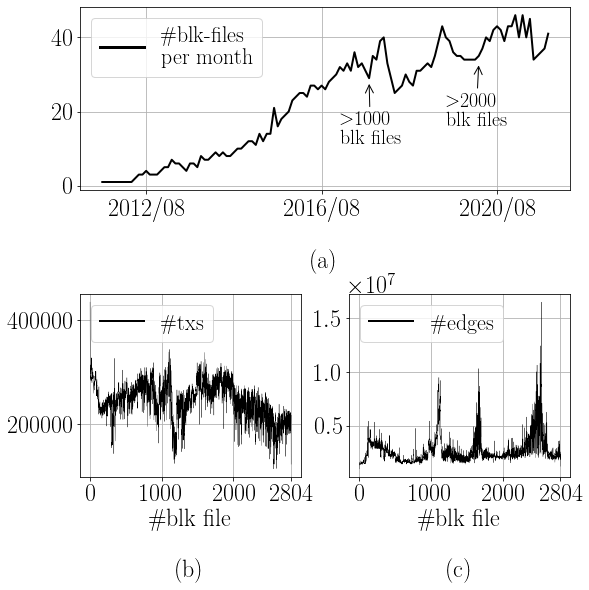

2369: 25% coinjoin edges in blk file
1782: 22% coinjoin edges in blk file
2264: 22% coinjoin edges in blk file


In [4]:
# Transactions and edges per blk file

df_blkfiles = DF["stats_blk_files"]
df_blkfiles["timestamp"] = list(map(lambda x:  datetime.strptime(x.split("+")[0],'%Y-%m-%d %H:%M:%S').strftime("%Y/%m"), df_blkfiles["ts"]))
df_blkfiles_gr = df_blkfiles.groupby(["timestamp"]).size()[:-1]
df_coinj_edges = DF["stats_coinj_vs_total_edges_blk"]["coinj_edges"]

# SMAs (optional)
#df_blkfiles_ma_index = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["blk_file_nr"]
#df_blkfiles_ma_edges = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["edges"]
#df_blkfiles_ma_txs = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["txs"]
# Create figure with size 5x3.15 inches
f, axs = plt.subplot_mosaic([['2', '2'],
                             ['0', '1']],
                              figsize=(8, 8))

# Plot chart
axs["0"].plot(df_blkfiles["blk_file_nr"],df_blkfiles["txs"], color="k", linewidth = 0.3, label="\#txs")
axs["1"].plot(df_blkfiles["blk_file_nr"],df_blkfiles["edges"], color="k", linewidth = 0.3, label="\#edges")
axs["2"].plot(df_blkfiles_gr.index,df_blkfiles_gr, color="k", linewidth = 2, label="\#blk-files\nper month")
#axs["1"].plot(df_blkfiles["blk_file_nr"],df_coinj_edges, color="#00629b", linewidth = 2, label="sma (k=10)")
#axs["0"].plot(df_blkfiles_ma_index,df_blkfiles_ma_txs, color="#00629b", linewidth = 2, label="sma (k=10)")


# Customize ticks and labels
axs["0"].tick_params(axis='both', which='major', labelsize=24)
axs["1"].tick_params(axis='both', which='major', labelsize=24)
axs["2"].tick_params(axis='both', which='major', labelsize=24)

axs["0"].xaxis.set_ticks([0,1000,2000,df_blkfiles["blk_file_nr"].iloc[-1]])
axs["1"].xaxis.set_ticks([0,1000,2000,df_blkfiles["blk_file_nr"].iloc[-1]])
axs["2"].xaxis.set_ticks(np.arange(12, 124, 48))

axs["0"].set_xlabel("\#blk file\n\n(b)", fontsize=24)
axs["1"].set_xlabel("\#blk file\n\n(c)", fontsize=24)
axs["2"].set_xlabel("\n(a)", fontsize=24)

axs["1"].yaxis.get_offset_text().set_fontsize(24)

axs["2"].annotate("$>$1000 \nblk files", xy=("2017/09", 28), xycoords='data',
            xytext=("2017/01", 11), textcoords='data',size=20,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
axs["2"].annotate("$>$2000\nblk files", xy=("2020/03", 33), xycoords='data',
            xytext=("2019/06", 16), textcoords='data',size=20,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

# Legend
lgnd1 = axs["0"].legend(fontsize=22, loc="upper left")
lgnd2 = axs["1"].legend(fontsize=22)
lgnd3 = axs["2"].legend(fontsize=22)

lgnd1.legendHandles[0]._linewidth = 2
lgnd2.legendHandles[0]._linewidth = 2
lgnd3.legendHandles[0]._linewidth = 3
plt.tight_layout(pad=0)
#Save figure and show
plt.savefig("./pictures/blk_files.pdf")
plt.show()
largest_shares = DF["stats_coinj_vs_total_edges_blk"].sort_values("share", ascending=False).iloc[0:3]
for _, i in largest_shares.iterrows():
    print(str(int(i["blk_file_nr"])) + ": " + str(int(i["share"])) + "% coinjoin edges in blk file")

### 3.3 Bitcoin - CoinJoin-adjusted User Graph

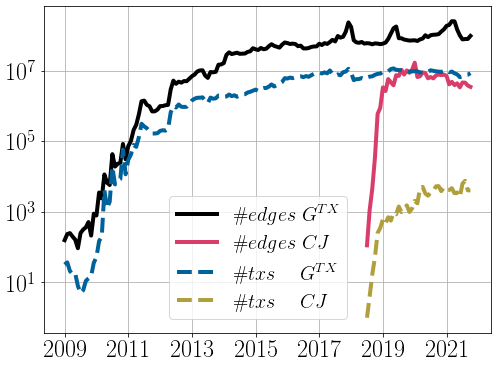

In January 2020, CoinJoin edges account for 23.22 % of the total number of edges


In [5]:
# (CoinJoin) Transaction/Edges per Month

df_edges  = DF["stats_metrics_summary_per_month_pubk"][:-1][["year","month","edges"]]
df_txs    = DF["stats_metrics_summary_per_month_pubk"][:-1][["year","month","txs"]]
df_cj_all = DF["coinj_metrics_over_time"][:-2]

# Create figure
plt.figure(figsize=(8, 6))

# Join year and month to get month-of-year `moy`
for i, j in zip(df_edges["year"], df_edges["month"]):
    df_edges.loc[(df_edges["year"].isin([i])) & (df_edges["month"].isin([j])),'moy'] = str(i)+"/"+str(j)

    
for i, j in zip(df_cj_all["year"], df_cj_all["month"]):
    df_cj_all.loc[(df_cj_all["year"].isin([i])) & (df_cj_all["month"].isin([j])),'moy'] = str(i)+"/"+str(j)
    
cjmoy = df_cj_all["moy"].drop_duplicates()

cjedges = df_cj_all.groupby(["year", "month"]).sum().reset_index()["edges"]
cjtxs = df_cj_all.groupby(["year", "month"]).sum().reset_index()["txs"]


# Plot chart
plt.plot(df_edges["moy"],df_edges["edges"], color="k", linewidth=4)
plt.plot(cjmoy,cjedges, color="#d93e6a", linewidth=4)
plt.plot(df_edges["moy"],df_txs["txs"], color="#00629b", linestyle='dashed', linewidth=4)
plt.plot(cjmoy,cjtxs, color="#b09f3d", linestyle='dashed', linewidth=4)


# Customize ticks and labels
ticks_position = list(set([i+"/1" for i in df_edges["year"].astype(str) if int(i) % 2 != 0]))
ticks          = [r"{}".format(tick.split("/")[0]) for tick in ticks_position]
plt.xticks(ticks_position, ticks, fontsize=24)
plt.yticks(fontsize=24)
plt.yticks(fontweight="book")
plt.gca().set_yscale('log')


# Legend
plt.legend([r"$\#edges\ G^{TX} \ $", r"$\#edges\ CJ$",
            r"$\#txs\ \ \ \ G^{TX}$", r"$\#txs\ \ \ \ CJ$"], 
          fontsize=20,loc='best', bbox_to_anchor=(0.7,0.45))

#Save figure and show
plt.savefig("./pictures/txs_edges_over_months_log.pdf")
plt.show()

cl_per_edges = round(cjedges.iloc[18]/df_edges.iloc[132]["edges"]*100, 2)
print(f"In January 2020, CoinJoin edges account for {cl_per_edges} % of the total number of edges")

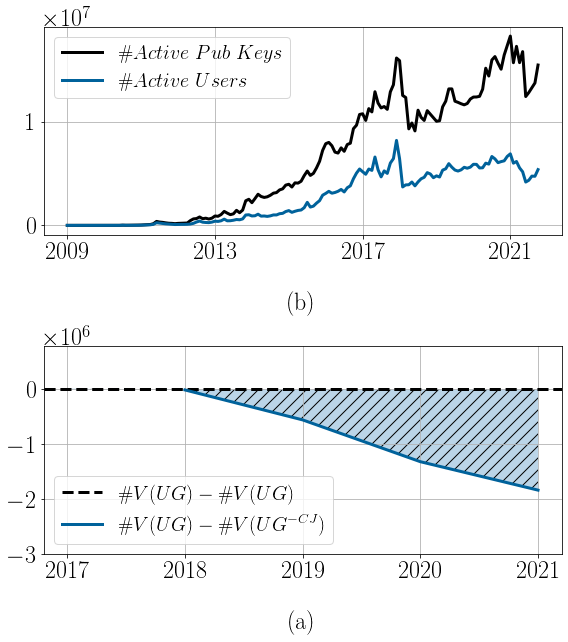

Final difference between the user graphs: -1,837,417 users


In [6]:
#df_cj_tp   = DF["coinj_throughput_over_time"][:-1]
df_ent_sum = DF["stats_summary"]
df_user    = DF["stats_metrics_summary_per_month_user_WCJ"][:-1][["year","month","active_users"]]
df_pubk    = DF["stats_metrics_summary_per_month_pubk"][:-1][["year","month","active_users"]]

df_user["moy"] = df_user["year"].astype(str)  + "/" + df_user["month"].astype(str) 


# Create figure 
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 9),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [3, 3]})

# Plot charts
axs[0].plot(df_user["moy"],df_pubk["active_users"], color="k", label=r'$\#Active\ Pub\ Keys$',linewidth=3)
axs[0].plot(df_user["moy"],df_user["active_users"], color="#00629b", label=r'$\#Active\ Users$',linewidth=3)

axs[1].axhline(0, color='black', lw=3, linestyle="dashed", label=r"$\# V(UG)-\# V(UG)$")
axs[1].plot(df_ent_sum["year"][8:],df_ent_sum["users"][9:]-df_ent_sum["users_wcj"][8:], 
            color="#00629b", label=r'$\# V(UG) - \# V(UG^{-CJ})$',linewidth=3)
axs[1].fill_between(df_ent_sum["year"][8:],df_ent_sum["users"][8:]-df_ent_sum["users_wcj"][8:], alpha=0.3, hatch=r"//")

#axs[2].plot(wasabi["moy"],wasabi["sat"]/1e8, color="#00629b", label="Wasabi",linewidth=4)
#axs[2].plot(wasabi["moy"],samurai["sat"], color="k", label="Samurai",linewidth=4)

# Customize ticks and labels
axs[0].xaxis.set_ticks(["2009/1","2013/1","2017/1","2021/1"])
axs[0].set_xticklabels(["2009","2013","2017", "2021"])
axs[0].yaxis.get_offset_text().set_fontsize(24)
axs[0].tick_params(axis='both', which='major', labelsize=24)
axs[0].set_xlabel("\n(b)", fontsize=24)

axs[1].yaxis.get_offset_text().set_fontsize(24)
axs[1].set_ylim(-3e6,0.8e6)
#axs[1].xaxis.set_ticks(["2019/1","2020/1","2021/1"])
#axs[1].set_xticklabels(["2019","2020", "2021"])
axs[1].tick_params(axis='both', which='major', labelsize=24)
#axs[1].set_ylabel("BTC", fontsize=24)
axs[1].set_xlabel("\n(a)", fontsize=24)
#axs[1].set_yscale('log')

#axs[2].yaxis.get_offset_text().set_fontsize(24)
#axs[2].xaxis.set_ticks(["2019/1","2020/1","2021/1"])
#axs[2].set_xticklabels(["2019","2020", "2021"])
#axs[2].tick_params(axis='both', which='major', labelsize=24)
#axs[2].set_ylabel("BTC", fontsize=24, fontweight="ultralight")
#axs[2].set_xlabel("\n(c)", fontsize=24, fontweight="ultralight")
#axs[2].set_yscale('log')
plt.tight_layout(pad=1)

# Legend
axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
#axs[2].legend(fontsize=20)

#Save figure and show
plt.savefig("./pictures/user_overview.pdf")
plt.show()
diff = int(df_ent_sum['users'][-1:]-df_ent_sum['users_wcj'][-1:])
print("Final difference between the user graphs: {:,.0f} users".format(diff))

In [29]:
df_price = DF["price_txs_edges_per_month"][27:-1]
df_pubk  = DF["stats_metrics_summary_per_month_pubk"][:-1][["year","month","users"]]
df_pubk.columns = ["year", "month", "pubkeys"]
df_price = pd.merge(df_price, df_pubk[-58:],  how='left', left_on=['year','month'], right_on = ['year','month'])

# Create figure with size 5x3.15 inches
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

df = df_price.sort_values("close")
X = np.array(df["close"])
Y = np.array(df["users"])
Y2 = np.array(df["pubkeys"])

equation, Y_NEW, _  = get_fitting_result(X, Y)
equation2, Y_NEW2, _ = get_fitting_result(X, Y2)

def equ(x, c, e):
    return c*x**e
e, c   = least_squares_line(X, Y)
e2, c2 = least_squares_line(X, Y2)

sample_prices = np.append(np.arange(df_price["close"].iloc[0],
                                    df_price["close"].iloc[-2], 10000),
                          df_price["close"].iloc[-1])

line  = equ(sample_prices, c, e)
line2 = equ(sample_prices, c2, e2)


# Plot chart
axs[0].scatter(X,Y, s=100, color="#00629b", marker="X", label="\#Active Users")
axs[0].plot(X, np.exp(clf.predict(_X)), linewidth=4, color= "#000099", linestyle=(0, (5, 5)))
#axs[0].plot(sample_prices, line, linewidth=4, color= "k", linestyle=(0, (5, 5)))
axs[0].plot(X, Y_NEW, linewidth=4, color= "k", linestyle=(0, (5, 5)))
axs[1].scatter(X,Y2, s=100, color="#00629b", marker="X", label="\#Active Pub Keys")
#axs[1].plot(sample_prices, line2, linewidth=4, color= "k", linestyle=(0, (5, 5)))
axs[1].plot(X, Y_NEW2, linewidth=4, color= "k", linestyle=(0, (5, 5)))


# Customize ticks and labels
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].tick_params(axis='both', which='both', labelsize=24)
#axs[0].set_xlabel(r"$USD/BTC$", fontsize=24)
#axs[0].set_ylim(2.9e6,1e7)
#axs[0].set_xlim(500,100000)
#axs[0].set_title(equation,x=0.51, y=1.0, pad=-205, fontsize=21)
#axs[0].yaxis.set_ticks([2.9e6, 1e7])

# Customize ticks and labels
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].tick_params(axis='both', which='both', labelsize=24)
axs[1].set_xlabel(r"$USD/BTC$", fontsize=24)
axs[1].set_ylim(1.2e7,3.6e7)
axs[1].set_xlim(500,100000)
axs[1].set_title(equation2,x=0.51, y=1.0, pad=-205, fontsize=21)
axs[1].yaxis.set_ticks([1.5e7,2e7, 3e7])


# Legend
lgnd = axs[0].legend(fontsize=24)
lgnd.legendHandles[0]._sizes = [500]
lgnd.legendHandles[0]._linewidths = [3]

lgnd = axs[1].legend(fontsize=24)
lgnd.legendHandles[0]._sizes = [500]
lgnd.legendHandles[0]._linewidths = [3]

plt.tight_layout(pad=2)

#Save figure and show
plt.savefig("./pictures/users_vs_price.pdf")
plt.show()
print("From")
print(int(df_price.iloc[0][["year", "month"]][0]),int(df_price.iloc[0][["year", "month"]][1]))
print("To")
print(int(df_price.iloc[-1][["year", "month"]][0]),int(df_price.iloc[-1][["year", "month"]][1]))
print("\nHighest prices:")
df_price.sort_values("close")[::-1][0:5]

KeyError: 'price_txs_edges_per_month'

In [44]:
import statsmodels.api as sm

model = sm.GLM(np.log(Y), X, family=sm.families.Poisson(link=sm.families.links.log()))
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   58
Model:                            GLM   Df Residuals:                       57
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1181.7
Date:                Sun, 13 Feb 2022   Deviance:                       2097.4
Time:                        14:58:26   Pearson chi2:                 5.93e+03
No. Iterations:                     7   Pseudo R-squ. (CS):         -5.060e+15
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6.403e-05   1.23e-06     52.132      0.0

In [86]:
from sklearn.linear_model import TweedieRegressor
clf = TweedieRegressor(power=0, alpha=0.5, link='log')

_X = np.log(X).reshape(-1, 1)
_Y = np.log(Y)
clf.fit(_X, _Y)


clf.predict(_X)

/home/nero/python/wu/btc/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/nero/python/wu/btc/lib/python3.8/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)


array([15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067, 15.47490067, 15.47490067,
       15.47490067, 15.47490067, 15.47490067])

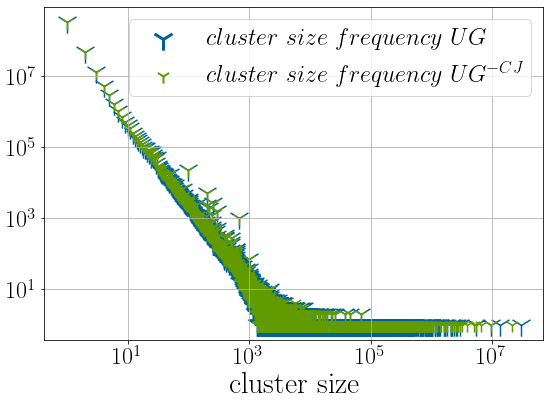

In [59]:
dfcug = DF["usergraph_clustersizes_distribution_UG"][:-1]
dfcwj = DF["usergraph_clustersizes_distribution_WCJ"][:-1]

#Create figure
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# Plot chart

axs.scatter(dfcug["clustersize"],dfcug["occurencies"], s=500, color="#00629b", alpha=1,
            marker="1", label=r"$cluster\ size\ frequency\ UG$")
axs.scatter(dfcwj["clustersize"],dfcwj["occurencies"], s=200, color="#629b00", 
            marker="1", label=r"$cluster\ size\ frequency\ UG^{-CJ}$")

# Customize ticks and labels
axs.set_xscale('log')
axs.set_yscale('log')
axs.tick_params(axis='both', which='major', labelsize=24)
axs.set_xlabel("cluster size", fontsize=30)

# Legend
lgnd = axs.legend(fontsize=24)
lgnd.legendHandles[0]._sizes = [500]
lgnd.legendHandles[0]._linewidths = [3]
lgnd.legendHandles[1]._sizes = [200]
lgnd.legendHandles[1]._linewidths = [2]

plt.tight_layout(pad=2)
#Save figure and show
plt.savefig("./pictures/clustersize_dist.pdf")
plt.show()

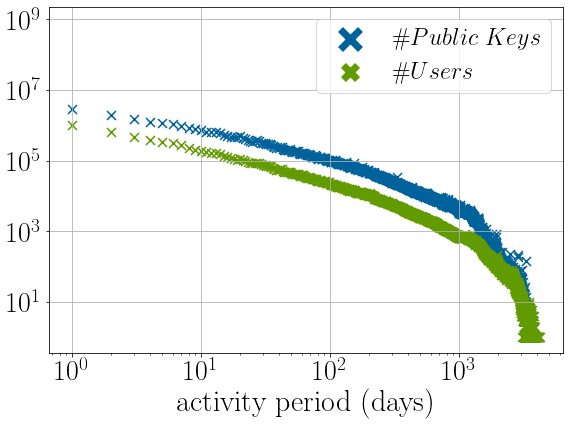

93.88% of addresses were used only on a single day
95.32% of addresses were used for less than 10 days
96.57% of users were seen only on a single day
97.58% of users were seen for less than 10 days
  2    publik keys were active for more than 4018 days (11 years)
  8    entities were active for more than 4018 days (11 years)

On average, users are active over a period of 10.19 days with a variance of 6,702.09
On average, addresses are active over a period of 5.28 days with a variance of 4,051.93
Most active public key: 17THx8KXVDnHM7arcoTxdvmYhS9rP141c2

Public keys:
      active_days  occurencies
3704         4136            1
3703         4056            1
3702         3976            1
3701         3948            1
3700         3932            1
...           ...          ...
4               4      1264056
3               3      1507174
2               2      1951001
1               1      2988979
0               0    816382701

[3705 rows x 2 columns]

Users:
      active_days  oc

In [53]:
df_ent_active = DF["stats_active_time_G"][::-1]
df_uwcj       = DF["stats_active_time_WCJ"][::-1]
df_avgwcj     = DF["stats_active_time_avg_WCJ"].iloc[0]
df_avg        = DF["stats_active_time_avg_G"].iloc[0]


f, axs = plt.subplots(1, 1,figsize=(8, 6),gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1]})

# Plot charts

axs.scatter(df_ent_active["active_days"],df_ent_active["occurencies"], s=80, color="#00629b",
               marker="x", label=r"$\# Public\ Keys$")
axs.scatter(df_uwcj["active_days"],df_uwcj["occurencies"], s=80, color="#629b00",
               marker="x", label=r"$\# Users$")

# Customize ticks and labels
axs.tick_params(axis='both', which='major', labelsize=28)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel("activity period (days)", fontsize=30)

# Legend
lgnd = axs.legend(fontsize=24)
lgnd.legendHandles[0]._linewidths = [7]
lgnd.legendHandles[1]._linewidths = [7]
lgnd.legendHandles[0]._sizes = [200]
lgnd.legendHandles[1]._sizes = [200]

plt.tight_layout(pad=1)
#Save figure and show
plt.savefig("./pictures/activity_period.pdf")
plt.show()
less10 = sum(df_ent_active[df_ent_active["active_days"] < 10]["occurencies"])
less10 = round(less10/sum(df_ent_active["occurencies"])*100, 2)     
less0 = sum(df_ent_active[df_ent_active["active_days"] < 1]["occurencies"])
less0 = round(less0/sum(df_ent_active["occurencies"])*100, 2)     

less10_u = sum(df_uwcj[df_uwcj["active_days"] < 10]["occurencies"])
less10_u = round(less10_u/sum(df_uwcj["occurencies"])*100, 2)     
less0_u = sum(df_uwcj[df_uwcj["active_days"] < 1]["occurencies"])
less0_u = round(less0_u/sum(df_uwcj["occurencies"])*100, 2)  

print("{}% of addresses were used only on a single day".format(less0))
print("{}% of addresses were used for less than 10 days".format(less10))

print("{}% of users were seen only on a single day".format(less0_u))
print("{}% of users were seen for less than 10 days".format(less10_u))

active = len(df_ent_active[df_ent_active["active_days"] >= 4018])
print("{:^6} publik keys were active for more than 4018 days (11 years)".format(active))
active = len(df_uwcj[df_uwcj["active_days"] >= 4018])
print("{:^6} entities were active for more than 4018 days (11 years)".format(active))
print("\nOn average, users are active over a period of {:,.2f} days with a variance of {:,.2f}".format(df_avg[0], 
                                                                                                       df_avg[1]))
print("On average, addresses are active over a period of {:,.2f} days with a variance of {:,.2f}".format(df_avgwcj[0], 
                                                                                                         df_avgwcj[1]))

print("Most active public key: {}".format(DF["stats_most_active_public_key"].iloc[0][0]))
print("\nPublic keys:")
print(df_ent_active)
print("\nUsers:")
print(df_uwcj)

### 3.4. Network Properties

Total:
2012:  1.1180
2013:  1.1361
2014:  1.1391
2015:  1.1362
2016:  1.1270
2017:  1.1147
2018:  1.1046
2019:  1.0977
2020:  1.0925
2021:  1.0883
---
T3:
2012:  1.1549
2013:  1.5142
2014:  1.0563
2015:  0.9207
2016:  0.8515
2017:  0.7666
2018:  0.7753
2019:  1.0076
2020:  1.1352
2021:  1.0556
---
T5:
2012:  1.1180
2013:  1.1361
2014:  1.1883
2015:  1.2339
2016:  0.9593
2017:  0.8482
2018:  0.8123
2019:  0.8176
2020:  0.9072
2021:  1.0482


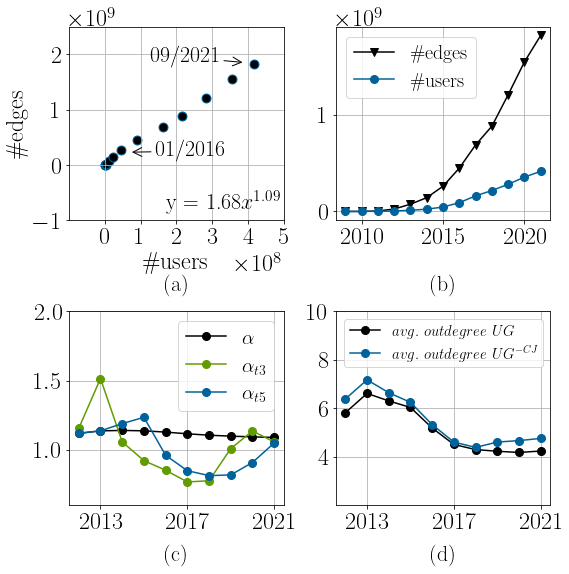

Out degree 2012: 6.38
Out degree 2021: 4.75


In [64]:
# Densification

df_cncwcj = DF["stats_user_count_cum_WCJ"].sort_values("year").set_index("year")
df_out = DF["stats_avg_outdegree_WCJ"].sort_values("year", ignore_index=True)[3:]
df_out_ug = DF["stats_avg_outdegree_UG"].sort_values("year", ignore_index=True)[3:]
 
dense_pl = {}
for i in range(4,14):
    year = 2008 + i
    cnc, cec = df_cncwcj.addrs_c[0:i], df_cncwcj.edges_c[0:i]
    dense_pl[year],c = least_squares_line(cnc, cec)

dense_pl_t3 = {}   
dense_pl_t5 = {}
for i in range(4,14):
    year = 2008 + i
    cnc, cec = df_cncwcj.addrs_c[0:i], df_cncwcj.edges_c[0:i]
    dense_pl_t3[year],c = least_squares_line(cnc, cec, 3)
    dense_pl_t5[year],c = least_squares_line(cnc, cec, 5)  
        
    
equ = "y = " + str(round(c, 2)) +"$x^{" + str(round(dense_pl[2021], 2)) + "}$"

print("Total:")
for year, e in dense_pl.items():
    print("{:<4}:  {:>5.4f}".format(year, e))
print("---\nT3:")
for year, e in dense_pl_t3.items():
    print("{:<4}:  {:>5.4f}".format(year, e))
print("---\nT5:")
for year, e in dense_pl_t5.items():
    print("{:<4}:  {:>5.4f}".format(year, e))

# Create figure with size 4x4 inches
f, axs = plt.subplots(2, 2,figsize=(8, 8))

# Plot chart
axs[0][0].scatter(df_cncwcj["addrs_c"],df_cncwcj["edges_c"], s=80, color="k", edgecolors="#00629b")
axs[1][0].plot(df_cncwcj.index[3:], dense_pl.values(), color="k", marker="o", markersize=8, label="$\\alpha$")
axs[1][0].plot(df_cncwcj.index[3:], dense_pl_t3.values(), color="#629b00", marker="o", markersize=8, label="$\\alpha_{t3}$")
axs[1][0].plot(df_cncwcj.index[3:], dense_pl_t5.values(), color="#00629b", marker="o", markersize=8, label="$\\alpha_{t5}$")
axs[0][1].plot(df_cncwcj.index, df_cncwcj["edges_c"], color="k", marker="v", markersize=8, label="\#edges")
axs[0][1].plot(df_cncwcj.index, df_cncwcj["addrs_c"], color="#00629b", marker="o", markersize=8, label="\#users")
axs[1][1].plot(df_out_ug["year"], df_out_ug["avg_outdegree"], color="k", marker="o", markersize=8, label="$avg.\ out\-degree\ UG$")
axs[1][1].plot(df_out["year"], df_out["avg_outdegree"], color="#00629b", marker="o", markersize=8, label="$avg.\ out\-degree\ UG^{-CJ}$")


# Add month/year annoations
axs[0][0].annotate("09/2021", xy=(int(3.9e8), int(1.85e9)), xycoords='data',
            xytext=(int(1.25e8), int(1.85e9)), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), fontsize=22)
axs[0][0].annotate("01/2016", xy=(int(0.7e8), int(0.23e9)), xycoords='data',
            xytext=(int(1.4e8), int(0.15e9)), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), fontsize=22)

axs[0][0].annotate(equ, xy=(int(1.7e8), int(-8e8)), xycoords='data',
            xytext=(int(1.7e8), int(-8e8)), textcoords='data', fontsize=22)


axs[0][0].set_xlabel('\#users', fontsize=24)
axs[0][0].set_ylabel('\#edges', fontsize=24)


axs[0][0].xaxis.get_offset_text().set_fontsize(24)
axs[0][0].yaxis.get_offset_text().set_fontsize(24)
axs[0][1].yaxis.get_offset_text().set_fontsize(24)

axs[0][1].xaxis.set_ticks([2010,2015,2020])
axs[1][0].xaxis.set_ticks([2013,2017,2021])
axs[1][1].xaxis.set_ticks([2013,2017,2021])
axs[0][0].set_xticks([0, 1e8, 2e8, 3e8, 4e8, 5e8])
axs[1][1].set_yticks([4, 6, 8, 10])

axs[1][0].set_ylim([0.6, 2])
axs[1][1].set_ylim(2, 10)
axs[0][0].set_ylim(-1e9, 0.25e10)
axs[0][0].set_xlim(-1e8, 5e8)

axs[0][1].legend(fontsize=20)
axs[1][0].legend(fontsize=20)
axs[1][1].legend(fontsize=15)



axs[0][0].tick_params(axis='both', which='major', labelsize=24)
axs[0][1].tick_params(axis='both', which='major', labelsize=24)
axs[1][0].tick_params(axis='both', which='major', labelsize=24)
axs[1][1].tick_params(axis='both', which='major', labelsize=24)

axs[0][0].set_title('(a)', y=1.0, pad=-265, fontsize=22)
axs[0][1].set_title('(b)', y=1.0, pad=-265, fontsize=22)
axs[1][0].set_title('(c)', y=1.0, pad=-250, fontsize=22)
axs[1][1].set_title('(d)', y=1.0, pad=-250, fontsize=22)

#axs[0][0].set_title(equ,x=0.72, y=1, pad=-180, fontsize=24, fontweight="ultralight")

plt.tight_layout(pad=1)
#Save figure and show
plt.savefig("./pictures/densification_over_time.pdf")
plt.show()

print("Out degree {}: {}".format(int(df_out.iloc[0][0]), df_out.iloc[0][1]))
print("Out degree {}: {}".format(int(df_out.iloc[-1][0]), df_out.iloc[-1][1]))

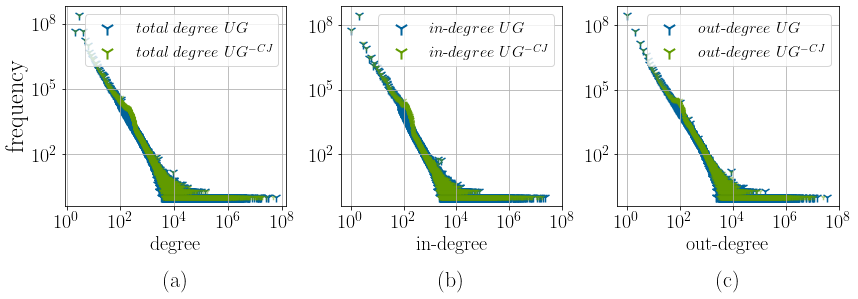

In [66]:
#
# DEGREE DISTRIBUTION 
#
# The power law coefficients are calculated using plfit.c, available
# here https://github.com/ntamas/plfit 

df_ddt = DF["stats_degree_distribution_total_UG"]
df_ddi = DF["stats_degree_distribution_out_degree_UG"]
df_ddo = DF["stats_degree_distribution_in_degree_UG"]

df_ddt_wcj = DF["stats_degree_distribution_total_WCJ"]
df_ddi_wcj = DF["stats_degree_distribution_out_degree_WCJ"]
df_ddo_wcj = DF["stats_degree_distribution_in_degree_WCJ"]

# Create figure with size 4x4 inches
f, axs = plt.subplots(1, 3,figsize=(12, 4))

# Plot total degree
axs[0].scatter(df_ddt["degree"],df_ddt["frequency"], s=100, color="#00629b", marker="1", label="$total\ degree\ UG$")
axs[0].scatter(df_ddt_wcj["degree"],df_ddt_wcj["frequency"], s=30, color="#629b00", alpha=0.5, marker="1", label="$total\ degree\ UG^{-CJ}$")

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_xlabel('degree', fontsize=20)
axs[0].set_ylabel('frequency', fontsize=24)
axs[0].set_xticks([1, 1e2, 1e4, 1e6, 1e8])
#axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes , color="k", ls="--", label='_nolegend_')

# Plot in degree
axs[1].scatter(df_ddi["degree"],df_ddi["frequency"], s=100, color="#00629b", marker="1", label="$in$-$degree\ UG$")
axs[1].scatter(df_ddi_wcj["degree"],df_ddi_wcj["frequency"], s=30, color="#629b00", alpha=0.5, marker="1", label="$in$-$degree\ UG^{-CJ}$")
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('in-degree', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_xticks([1, 1e2, 1e4, 1e6, 1e8])

# Plot out degree
axs[2].scatter(df_ddo["degree"],df_ddo["frequency"], s=100, color="#00629b", marker="1", label="$out$-$degree\ UG$")
axs[2].scatter(df_ddo_wcj["degree"],df_ddo_wcj["frequency"], s=30, color="#629b00", alpha=0.5, marker="1", label="$out$-$degree\ UG^{-CJ}$")
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('out-degree', fontsize=20)
axs[2].tick_params(axis='both', which='major', labelsize=20)
axs[2].set_xticks([1, 1e2, 1e4, 1e6, 1e8])

axs[0].set_title('(a)', y=1.0, pad=-280, fontsize=22)
axs[1].set_title('(b)', y=1.0, pad=-280, fontsize=22)
axs[2].set_title('(c)', y=1.0, pad=-280, fontsize=22)

lgnd1 = axs[0].legend(fontsize=16)


lgnd2 = axs[1].legend(fontsize=16)
lgnd3 = axs[2].legend(fontsize=16)


lgnd1.legendHandles[0]._linewidths = [2]
lgnd1.legendHandles[1]._linewidths = [2]
lgnd1.legendHandles[0]._sizes = [200]
lgnd1.legendHandles[1]._sizes = [200]
lgnd1.legendHandles[1]._alpha = 1

lgnd2.legendHandles[0]._linewidths = [2]
lgnd2.legendHandles[1]._linewidths = [2]
lgnd2.legendHandles[0]._sizes = [200]
lgnd2.legendHandles[1]._sizes = [200]
lgnd2.legendHandles[1]._alpha = 1

lgnd3.legendHandles[0]._linewidths = [2]
lgnd3.legendHandles[1]._linewidths = [2]
lgnd3.legendHandles[0]._sizes = [200]
lgnd3.legendHandles[1]._sizes = [200]
lgnd3.legendHandles[1]._alpha = 1

plt.tight_layout(pad=1)
#Save figure and show
plt.savefig("./pictures/degree_distributions.pdf", bbox_inches='tight')
plt.show()

In [30]:
# Create degree files to calculate power law exponent
%run bitcoin_graph/create_degree_file.py

input path to store degree-file: ./powerlaw_distribution/powerlaw_distribution
1/3
2/3
3/3


<Figure size 432x288 with 0 Axes>

In [31]:
# Calculate power law exponents using plfit.c (https://github.com/ntamas/plfit)
! ./plfit/build/src/plfit powerlaw_distribution/powerlaw_distribution_total.txt

powerlaw_distribution/powerlaw_distribution_total.txt:
	Discrete MLE
	alpha =      1.83495
	xmin  =  10683.00000
	L     = -83515.49631
	D     =      0.01278



In [32]:
! ./plfit/build/src/plfit powerlaw_distribution/powerlaw_distribution_in.txt

powerlaw_distribution/powerlaw_distribution_in.txt:
	Discrete MLE
	alpha =      2.19265
	xmin  =    196.00000
	L     = -2998737.38657
	D     =      0.00778



In [33]:
! ./plfit/build/src/plfit powerlaw_distribution/powerlaw_distribution_out.txt

powerlaw_distribution/powerlaw_distribution_out.txt:
	Discrete MLE
	alpha =      2.00723
	xmin  =  37136.00000
	L     = -15997.67440
	D     =      0.01559



### Outtakes

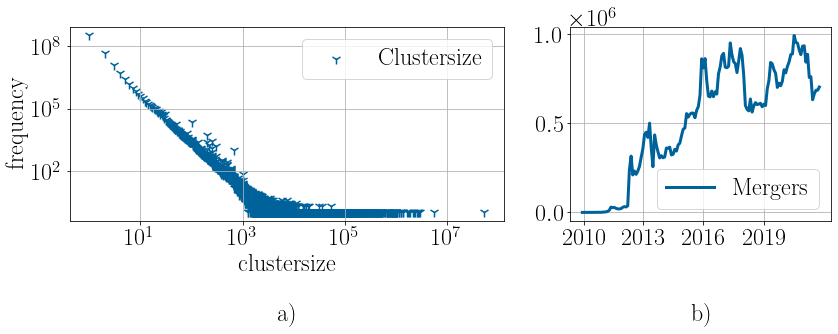

In [71]:
df_   = DF["usergraph_mergers_over_date"][:-1]
df_["moy"] = df_["year"].astype(str)  + "/" + df_["month"].astype(str) 
dfcwj = DF["usergraph_clustersizes_distribution_WCJ"][:-1]
# Create figure with size 5x3.15 inches
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5),
                       gridspec_kw={
                           'width_ratios': [2.5, 1.5],
                           'height_ratios': [3]})



# Plot chart
axs[0].scatter(dfcwj["clustersize"],dfcwj["occurencies"], s=100, color="#00629b", marker="1", label="Clustersize")
axs[1].plot(df_["moy"],df_["mergers"], color="#00629b", label="Mergers",linewidth=3)

# Customize ticks and labels
ticks_position = ['2010/2', '2013/1', '2016/1', '2019/1']
ticks          = [r"{}".format(tick.split("/")[0]) for tick in ticks_position]
axs[1].xaxis.set_ticks(ticks_position)
axs[1].set_xticklabels(ticks)

axs[0].tick_params(axis='both', which='major', labelsize=24)
axs[1].tick_params(axis='both', which='major', labelsize=24)


axs[0].set_xlabel("clustersize\n\na)", fontsize=24)
axs[0].set_ylabel("frequency", fontsize=24)
axs[1].set_xlabel("\n\nb)", fontsize=24)

axs[0].set_xscale('log')
axs[0].set_yscale('log')

axs[1].yaxis.get_offset_text().set_fontsize(24)


# Legend
axs[0].legend(fontsize=24)
axs[1].legend(fontsize=24)

plt.tight_layout(pad=2)
#Save figure and show
plt.savefig("./pictures/usergraph.pdf")
plt.show()

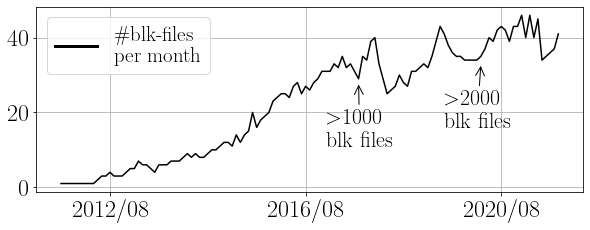

In [10]:
# Transactions and edges per blk file

df_blkfiles = DF["stats_blk_files"]
df_blkfiles["timestamp"] = list(map(lambda x: datetime.utcfromtimestamp(x).strftime("%Y/%m"), df_blkfiles["ts"]))
df_blkfiles_gr = df_blkfiles.groupby(["timestamp"]).size()[:-1]


# SMAs (optional)
#df_blkfiles_ma_index = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["blk_file_nr"]
#df_blkfiles_ma_edges = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["edges"]
#df_blkfiles_ma_txs = df_blkfiles.groupby(df_blkfiles.index // 200).mean()["txs"]
# Create figure with size 5x3.15 inches
f, axs = plt.subplots(1, 1,figsize=(8, 3),gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1]})

# Plot chart
axs.plot(df_blkfiles_gr.index,df_blkfiles_gr, color="k", label="\#blk-files\nper month")

# Customize ticks and labels
axs.tick_params(axis='both', which='major', labelsize=24)

axs.xaxis.set_ticks(np.arange(12, 124, 48))


axs.annotate("$>$1000 \nblk files", xy=("2017/09", 28), xycoords='data',
            xytext=("2017/01", 11), textcoords='data',size=22,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))
axs.annotate("$>$2000\nblk files", xy=("2020/03", 33), xycoords='data',
            xytext=("2019/06", 16), textcoords='data',size=22,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

# Legend
lgnd3 = axs.legend(fontsize=21)


lgnd3.legendHandles[0]._linewidth = 3
plt.tight_layout(pad=0)
#Save figure and show
plt.savefig("./pictures/blk_files_intro.pdf")
plt.show()